# Imports:

In [50]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import json
import matplotlib.pyplot as plt
import openpyxl

plt.rcParams['figure.figsize'] = (20, 10)

# Definition of functions:

In [3]:
# search for columns_selection
def determine_columns_sel(dataset_name : str):

    # initialize columns_sel as list
    columns_sel = []
    if dataset_name == 'sepsis_cases_1':
            columns_sel = ['Diagnose', 'mean_open_cases', 'Age', 'std_Leucocytes', 'std_CRP']#sepsis_cases_1
    elif dataset_name == 'sepsis_cases_2':
            columns_sel = ['Diagnose', 'mean_open_cases', 'mean_hour', 'DisfuncOrg']#sepsis_cases_2
    elif dataset_name == 'sepsis_cases_4':
            columns_sel = ['Diagnose', 'mean_open_cases', 'Age', 'org:group_E', 'std_CRP', 'DiagnosticECG']#sepsis_cases_4
    elif dataset_name == 'bpic2011_f1':
            columns_sel = ['Diagnosis Treatment Combination ID', 'mean_open_cases', 'Diagnosis', 'Activity code_376400.0']#bpic2011_f1
    elif dataset_name == 'bpic2011_f2':
            columns_sel = ['Diagnosis Treatment Combination ID', 'Diagnosis', 'Diagnosis code', 'mean_open_cases', 'Activity code_376400.0', 'Age', 'Producer code_CHE1']#bpic2011_f2
    elif dataset_name == 'bpic2011_f3':
            columns_sel = ['Diagnosis Treatment Combination ID', 'Diagnosis', 'mean_open_cases', 'Diagnosis code', 'std_event_nr', 'mean_event_nr']#bpic2011_f3
    elif dataset_name == 'bpic2011_f4':
            columns_sel = ['Diagnosis Treatment Combination ID', 'Treatment code']#bpic2011_f4
    elif dataset_name == 'bpic2012_accepted':
            columns_sel = ['AMOUNT_REQ', 'Activity_O_SENT_BACK-COMPLETE', 'Activity_W_Valideren aanvraag-SCHEDULE', 'Activity_W_Valideren aanvraag-START']#bpic2012_accepted
    elif dataset_name == 'bpic2012_declined':
            columns_sel = ['AMOUNT_REQ', 'Activity_A_PARTLYSUBMITTED-COMPLETE', 'Activity_A_PREACCEPTED-COMPLETE', 'Activity_A_DECLINED-COMPLETE', 'Activity_W_Completeren aanvraag-SCHEDULE', 'mean_open_cases'] #bpic2012_declined
    elif dataset_name == 'bpic2012_cancelled':
            columns_sel = ['Activity_O_SENT_BACK-COMPLETE', 'Activity_W_Valideren aanvraag-SCHEDULE', 'Activity_W_Valideren aanvraag-START', 'AMOUNT_REQ', 'Activity_W_Valideren aanvraag-COMPLETE', 'Activity_A_CANCELLED-COMPLETE']#bpic2012_cancelled
    elif dataset_name == 'production':
            columns_sel = ['Work_Order_Qty', 'Activity_Turning & Milling - Machine 4', 'Resource_ID0998', 'Resource_ID4794', 'Resource.1_Machine 4 - Turning & Milling']#production
    return columns_sel

In [4]:
# collection of model and evaluation with test-set
def creation_and_prediction(dataset_name : str, columns_sel : list):

    # create model from train_anfis.py
    model = torch.load('models_lj/model_' + dataset_name + '.h5')
    # read in data from the test-set and separate into features and classification
    df_test = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + '_test.csv', header=0, sep=',')
    df_features = df_test[columns_sel]
    df_targets = df_test[['Classification']]
    # create torch array from features
    conv_test = torch.tensor(df_features.values, dtype=torch.float)
    # enable evaluation mode
    model.eval()
    with torch.no_grad():
        # predict outcome of each feature vector and split into prediction and certainty
        pred = model(torch.Tensor(conv_test))
        pred = torch.max(pred, 1)
    # we can call the outcome of the model: certainty since it is a summation of gaussian outcomes. This is why this NN is also refered to s XAI... certainty is already part of the outcome.
    df_targets = df_targets.assign(model_classification = pred.indices.detach().numpy(), model_certainty = pred.values.detach().numpy())
    return df_features, df_targets

In [5]:
# creation of certainty-histograms with 50 bins. Distinguishment between false and correct cases
def histplot_model_certainty_general(df_features : pd.DataFrame, df_targets : pd.DataFrame, dataset_name : str, savefig : bool=False):

    # check if classification of model is similar to the true classification of the feature vector
    false_class_df = df_features.loc[df_targets['Classification'] != df_targets['model_classification']]
    false_class_df['model_certainty'] = df_targets['model_certainty'].iloc[false_class_df.index]
    # create histogram for analysis purposes
    histplot_binning = np.linspace(0, df_targets['model_certainty'].max(), 50)
    # create visualization
    fig, axs = plt.subplots(1,1)
    sn.histplot(data=df_targets, x='model_certainty', bins=histplot_binning, color='blue', label='correctly classified')
    sn.histplot(data=false_class_df, x='model_certainty', bins=histplot_binning, color='red', label='incorrectly classified')
    axs.set_title(f'Model certainty comparison of all classifications {dataset_name}', fontsize=30)
    axs.legend(fontsize=20)
    axs.set_xlabel('model_certainty', fontsize=25)
    axs.set_ylabel('Count', fontsize=25)
    axs.tick_params(labelsize=20)
    if savefig == True:
        plt.savefig(f'results/further_analysis/comparison_certainty_histogram_correct_false/{dataset_name}_hist-certainty.png')
    plt.show()

In [6]:
# binning of ids that were assigned faulty corresponding to their prediction certainty
def binning_of_ids(df_targets : pd.DataFrame, bins_numb : int=10):

    # assign bin labels to predictions that were faulty. I.e. you can understand the bin labels as level of falseness.
    false_class_df = df_targets.loc[df_targets['Classification'] != df_targets['model_classification']]
    max = false_class_df['model_certainty'].max() # maximal model_certainty as bound
    bins = np.linspace(0, max, bins_numb+1)
    false_class_df = false_class_df.assign(certainty_bins = pd.cut(false_class_df['model_certainty'], bins, labels=range(1,bins_numb+1)))
    return false_class_df, max

In [7]:
# from these binnings we can create a histogram that show the occurences of all false classification based on their severeness
def create_hist_severeness(false_class_df : pd.DataFrame, dataset_name : str, max_certainty : float, savefig : bool=False):

    # create hue_column for better visualization and separation of severe cases
    fig, axs = plt.subplots(1,1)
    sn.histplot(data=false_class_df.loc[false_class_df['certainty_bins'] <= 5], x='certainty_bins',color='red', label='not severe cases')
    sn.histplot(data=false_class_df.loc[false_class_df['certainty_bins'] > 5], x='certainty_bins',color='darkred', label='severe cases')
    axs.set_title(f'False classification binning of {dataset_name}', fontsize=30)
    axs.legend(fontsize=20, loc='upper right')
    axs.set_xlabel('certainty_bins', fontsize=25)
    axs.set_ylabel('Count', fontsize=25)
    axs.tick_params(labelsize=20)
    props = dict(boxstyle='round', facecolor='grey', alpha=0.5)
    axs.text(0.89, 0.77, f'maximal \n model certainty \n = {max_certainty:.2f} ', horizontalalignment='center', verticalalignment='center', transform=axs.transAxes, bbox=props, fontsize=20)
    if savefig == True:
        plt.savefig(f'results/further_analysis/certainty_hist_false_classification/{dataset_name}_hist_certainty_false_class.png')
    plt.show()

In [8]:
# from the previous binning we can check which cases were bad (certainty_bins > level). Let's check the case_ids (from event log) and the dataset_ids (in csv-file) and create a dict for them
def get_bad_ids(false_class_df : pd.DataFrame, dataset_name : str, badness_level : int=5):

    len_df = pd.read_csv(f'dataset/{dataset_name}/len_test{dataset_name}.csv')
    bad_dataset_indices =  false_class_df.loc[false_class_df['certainty_bins']>badness_level].index.tolist()
    false_len_df = len_df.loc[bad_dataset_indices]
    index_relations = dict()
    for case in false_len_df.CaseID.unique().tolist():
        index_relations[case] = false_len_df.loc[false_len_df['CaseID'] == case].index.tolist()
    return index_relations

In [9]:
def are_bad_ids_prefixes(df_targets : pd.DataFrame, index_relations : dict, max_model_certainty : float, dataset_name : str, savefig : bool=False):

    len_df = pd.read_csv(f'dataset/{dataset_name}/len_test{dataset_name}.csv')

    for case in list(index_relations.keys()):
        all_indices = len_df.loc[len_df['CaseID'] == case].index.tolist()
        df_interim = df_targets.loc[all_indices]
        df_interim = df_interim.assign(Len = len_df.loc[all_indices, 'Len'])

        fig, axs = plt.subplots(1,1, figsize=(20, 7))
        plt.hlines(max_model_certainty, color='r', xmin=0, xmax=df_interim.Len.max()+1, linewidth=4, label='maximal model_certainty')
        plt.hlines(0.5*max_model_certainty, color='r', xmin=0, xmax=df_interim.Len.max()+1, linewidth=2, linestyles='dashed', label='threshold for bad_id_classification')
        sn.scatterplot(data=df_interim.loc[df_interim['model_classification'] == df_interim['Classification']], x='Len', y='model_certainty', color='green', linewidth=0, marker='o', s=70, label='correctly classified datapoints')
        sn.scatterplot(data=df_interim.loc[df_interim['model_classification'] != df_interim['Classification']], x='Len', y='model_certainty', color='orange', linewidth=0, marker='o', s=70, label='misclassified datapoints')
        plt.legend(fontsize=20)
        plt.suptitle(f'model_certainty against prefixes length (case=\'{case}\')', fontsize=30)
        plt.xlabel('Length of prefix', fontsize=25)
        plt.ylabel('model_certainty', fontsize=25)
        plt.ylim(-1,max_model_certainty+1)
        plt.tick_params(labelsize=20)
        if savefig == True:
            plt.savefig(f'results/further_analysis/certainty_case_detail/model_certainty_{dataset_name}_{case}.png')
        plt.show()

In [56]:
def get_feature_vectors(df_features : pd.DataFrame, index_relations : dict, dataset_name : str, savexlsx : bool=False):

    len_df = pd.read_csv(f'dataset/{dataset_name}/len_test{dataset_name}.csv')
    df_dict = dict()

    for case in list(index_relations.keys()):
        all_indices = len_df.loc[len_df['CaseID'] == case].index.tolist()
        df_dict[case] = df_features.loc[all_indices]
        df_dict[case] = df_dict[case].assign(Len = len_df.loc[all_indices, 'Len'])
        if savexlsx == True:
            df_dict[case].to_excel(f'results/further_analysis/selected_features_csv/{dataset_name}_{case}_selected_features.xlsx')
    return df_dict

In [11]:
# creation of json files in the result folder
def write_json(dictionary : dict, name : str):
    with open(f"results/further_analysis/json-files/{str(name)}.json", "w") as outfile:
        outfile.write(json.dumps(dictionary, sort_keys=True, sort_values=True))

# Main:
Here, I apply the functions from above.. typically, I iterate over all experiments and load the model.
Afterwards, I apply the functions to yield the analysis.
In some cases, I create additional plots or write json files to save the results of the analysis

In [54]:
datasets = ['sepsis_cases_1', 'sepsis_cases_2', 'sepsis_cases_4', 'production', 'bpic2011_f1', 'bpic2011_f2', 'bpic2011_f3', 'bpic2011_f4', 'bpic2012_accepted', 'bpic2012_declined', 'bpic2012_cancelled']

name = datasets[6]

C:\Users\lujae\anaconda3\envs\ppm_seminar\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


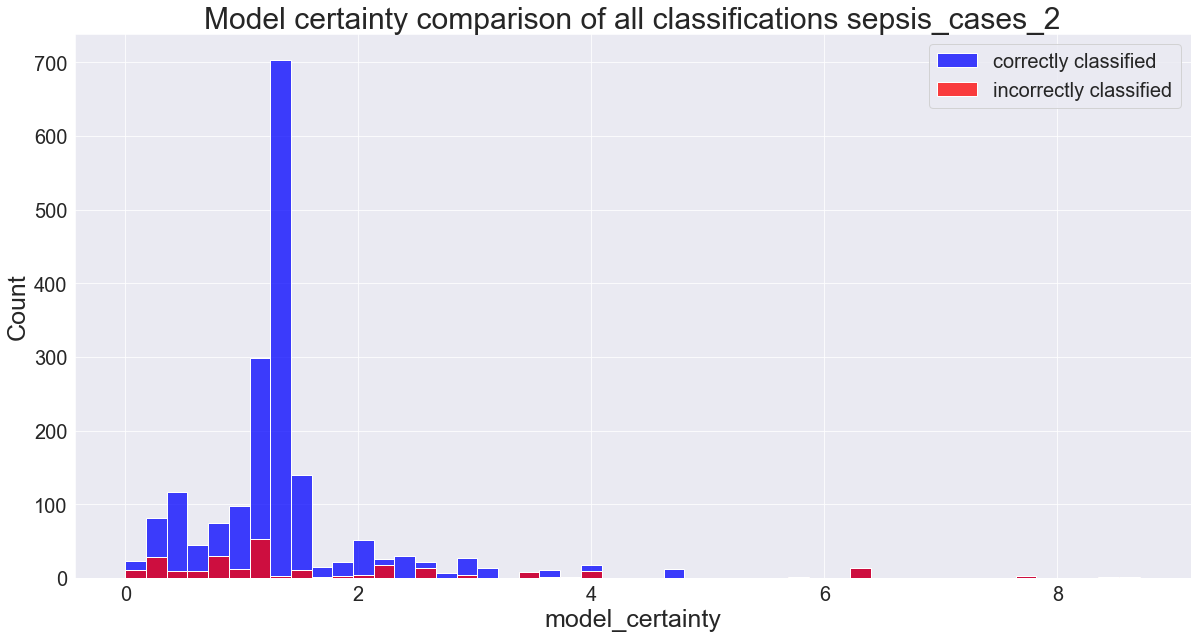

In [13]:
# creation of folder 'comparison_certainty_histogram_correct_false'
df_feat, df_targ = creation_and_prediction(name, determine_columns_sel(name))
histplot_model_certainty_general(df_feat, df_targ, name, savefig=False)

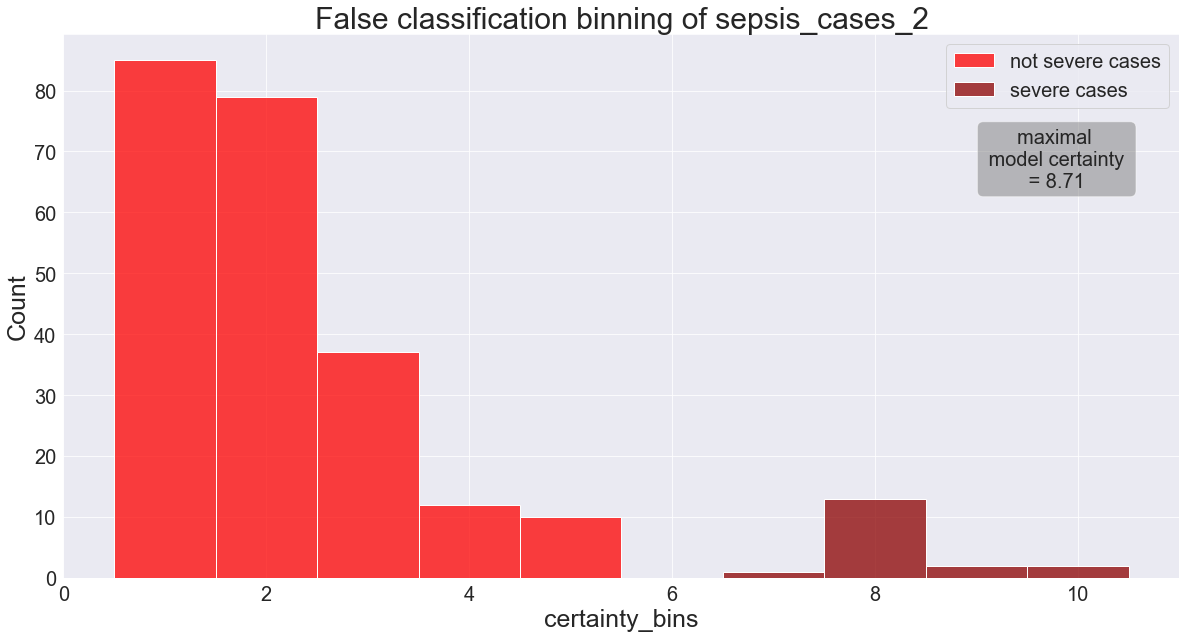

In [14]:
# creation of folder 'certainty_hist_false_classification'
_, df_targ = creation_and_prediction(name, determine_columns_sel(name))
fc_df, max = binning_of_ids(df_targ)
create_hist_severeness(fc_df, name, max, savefig=False)

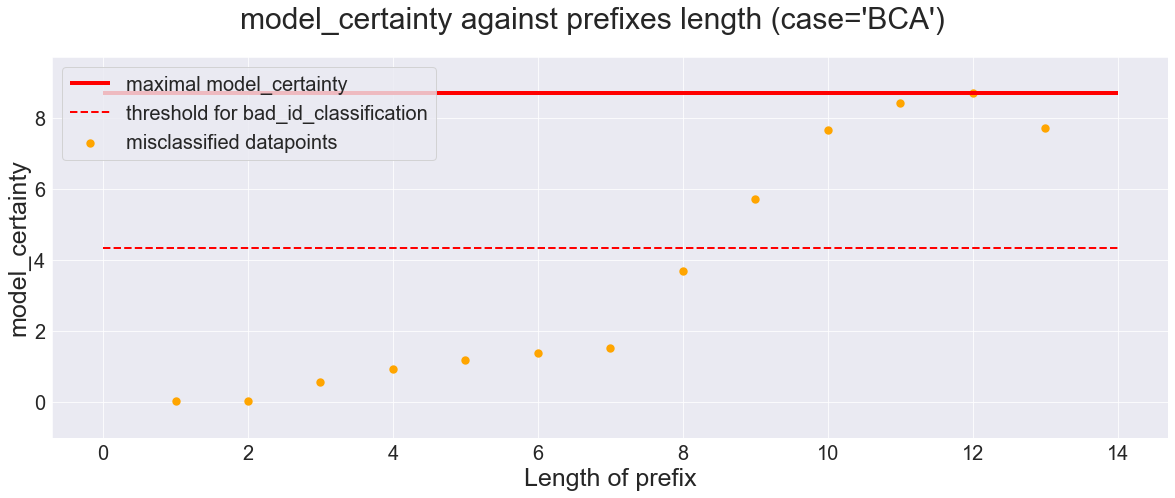

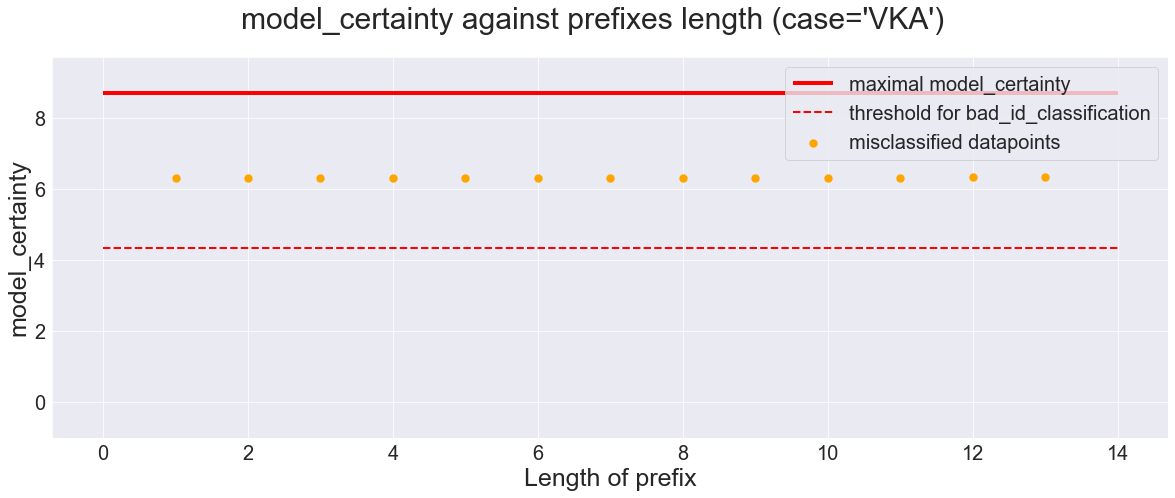

In [15]:
# creation of folder 'certainty_case_detail' 'production', 'bpic2011_f3'
_, df_targ = creation_and_prediction(name, determine_columns_sel(name))
fc_df, max = binning_of_ids(df_targ)
index_rel = get_bad_ids(fc_df, name)
are_bad_ids_prefixes(df_targ, index_rel, max, name, savefig=False)

In [55]:
# creation of feature_vector for cases that include severe false classifications
df_feat, df_targ = creation_and_prediction(name, determine_columns_sel(name))
fc_df, max = binning_of_ids(df_targ)
index_rel = get_bad_ids(fc_df, name)
df_dict = get_feature_vectors(df_feat, index_rel, name, savexlsx=False)

In [17]:
#write json file for cases that include sever false classifications
dict_cases = dict()

for name in datasets:
    _, df_targ = creation_and_prediction(name, determine_columns_sel(name))
    fc_df, max = binning_of_ids(df_targ)
    index_rel = get_bad_ids(fc_df, name)
    dict_cases[name] = sorted(list(index_rel.keys()))

In [18]:
#write_json(dict_cases, 'bad_case_ids')

In [19]:
# important event logs for later analysis: ['sepsis_cases_2', 'production', 'bpic2011_f3']